# 梯度下降
> 线性回归最常见的优化方法
## 步骤
<img alt="image.png" height="300" src="/Users/loneker/Desktop/d2l/pic/iShot_2024-02-26_12.51.49.png" width="600"/>

> 选择合适的学习率

## 小批量随机梯度下降
> 最常见的梯度下降版本
> 可以随机采样b个样本来近似损失，b是批量大小，要选择合适的批量大小

## 总结
> 梯度下降通过不断沿着反梯度方向更新参数求解
> 小批量随机梯度下降是深度学习默认的求解方法
> 两个重要的超参数是批量大小和学习率


# 线性回归的从零开始实现
> (不使用深度学习框架提供的计算)
> 包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [32]:
# %matplotlib inline 
# 可以在Ipython编译器里直接使用，功能是可以内嵌绘图，并且可以省略掉plt.show()这一步
import random  # 随机梯度下降、随机初始化权重
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集， W = [2, -3, 4]T,  b = 4.2
torch.normal(means, std, out=None)  均值、方差

In [57]:
def synthetic_data(w, b, num_examples) : 
    # 生成 y = wX + b + 噪声
    X = torch.normal(0, 1, (num_examples, len(w)))      # 均值为0，方差为1的随机数，长度和 w 一致
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)                 # 均值为0，方差为1的随机数，形状和 y 一致
    return X, y.reshape(-1, 1)                          # 将 x 和 y 以列向量的形式返回

true_w = torch.tensor([2, -3, 4], dtype=torch.float)
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

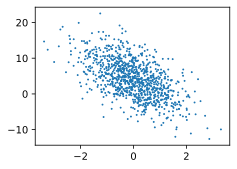

In [58]:
d2l.set_figsize()       # 设置图形大小，参数为宽度, 高度
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

定义一个data_iter函数，该函数接受批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量

In [60]:
def data_iter(batch_size, features, labels) : 
    num_examples = len(features)        # 有多少个样本
    indices = list(range(num_examples)) # 为样本进行编号, range表示从 0 到 n - 1， list表示转变成一个列表
    random.shuffle(indices)             # 将样本打乱，就可以随机顺序访问样本
                                        # random.shuffle()用于将一个列表中的元素打乱顺序，值得注意的是使用这个方法不会生成新的列表，只是将原列表的次序打乱。
    for i in range(0, num_examples, batch_size) : 
        batch_indices = torch.tensor(indices[i : min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]        # 相当于返回值

batch_size = 10

for X, y in data_iter(batch_size, features, labels) : 
    print(X, '\n', y, '\n')

tensor([[ 0.8324,  0.8792,  0.7733],
        [ 0.6155, -1.2677, -1.0795],
        [-0.1040,  0.0580, -0.4186],
        [-1.0203,  1.1708, -0.7127],
        [ 0.7962, -0.0073, -0.2815],
        [-0.3618, -2.0177,  0.5165],
        [-0.1188,  0.0675, -0.1466],
        [-1.3913, -0.3032, -0.3972],
        [ 0.1876, -0.8107,  0.8816],
        [ 0.8714, -1.4034,  0.5878]]) 
 tensor([[ 6.3383],
        [ 4.9062],
        [ 2.1243],
        [-4.2005],
        [ 4.6943],
        [11.5942],
        [ 3.1742],
        [ 0.7453],
        [10.5354],
        [12.5019]]) 

tensor([[ 0.9463,  0.5104,  0.6737],
        [ 0.8958,  0.6718, -0.4718],
        [-0.4682, -0.3673, -0.1918],
        [-0.2359, -0.5312, -1.4466],
        [ 1.1846, -0.4768, -1.0999],
        [-0.8986, -0.5132, -0.6511],
        [-0.6714, -0.2982,  1.2059],
        [-1.0671, -1.1459,  2.9636],
        [ 0.3916, -1.3908,  0.4574],
        [-0.2656,  1.0566, -0.1519]]) 
 tensor([[ 7.2723],
        [ 2.0977],
        [ 3.5879],
    

In [71]:
# 定义初始化模型参数
w = torch.normal(0, 0.01, size = (3, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# 定义模型
def linreg(X, w, b) : 
    """线性回归模型"""
    return torch.matmul(X, w) + b   # 返回预测

# 定义损失函数(使用均方误差)
def squared_loss(y_hat, y) : 
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2        # 有的可能是列向量，有可能是行向量，统一

# 定义优化算法
def sgd(params, lr, batch_size) : 
    # params : 参数，包括 W 和 b；  lr ： 是学习率；   batch_size : 
    """小批量随机梯度下降"""
    with torch.no_grad():    # 更新的时候不需要梯度计算
        for param in params : 
            param -= lr * param.grad / batch_size   # 损失函数的时候没有除均值
            param.grad.zero_()                      # 梯度设为0，下一次算梯度不会和上一次相关

# 训练过程
lr = 0.03
num_epochs = 3      # 将数据扫描三遍
net = linreg
loss = squared_loss

for epoch in range(num_epochs) :    # 扫几遍数据
    for X, y in data_iter(batch_size, features, labels) : # 每次拿出批量大小的X， y
        l = loss(net(X, w, b), y)   # 将数据放入网络，然后计算和真实值的损失, l 形状是批量大小的向量
        l.sum().backward()          # 求梯度
        sgd([w, b], lr, batch_size) # 求得梯度之后，使用参数的梯度更新参数, 这里batch_size不准确，最后一个批量数量可能不够
    with torch.no_grad() : 
        train_l = loss(net(features, w, b), labels)
        print(f'epoch{epoch + 1}, loss{float(train_l.mean()):f}')

print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

epoch1, loss0.057640
epoch2, loss0.000202
epoch3, loss0.000048
w的估计误差: tensor([ 0.0007, -0.0005,  0.0014], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0006], grad_fn=<RsubBackward1>)


# 线性回归的简单实现
> 通过使用深度学习框架来简洁地实现线性回归模型生成数据集

In [112]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3, 4], dtype=torch.float)
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

def load_array(data_arrays, batch_size, is_train = True) : 
    """构造一个pyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)          # * 表示接受任意多个参数并将其放在一个元组中
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))

[tensor([[-0.6283,  0.0818,  0.6784],
         [ 0.8396,  0.6347, -0.5548],
         [-1.0854,  1.2539, -0.5233],
         [-0.6493,  0.1027,  0.5924],
         [ 0.5522, -0.4120,  0.2053],
         [-0.7774, -0.6157,  1.0902],
         [ 1.2448, -0.8641, -0.1391],
         [ 1.7333, -0.8147,  0.4881],
         [-0.8509,  0.0124, -0.2011],
         [-2.5344, -0.3821, -1.5581]]),
 tensor([[ 5.3960],
         [ 1.7614],
         [-3.8125],
         [ 4.9772],
         [ 7.3680],
         [ 8.8405],
         [ 8.7362],
         [12.0593],
         [ 1.6610],
         [-5.9586]])]

In [114]:
from torch import nn    ## 'nn'是神经网络的缩写

net = nn.Sequential(nn.Linear(3, 1))        # 放到Sequential的容器中，相当于list of layers, 将所有的层按顺序放到一起
        # 可以直接使用Linear层，指定输入的维度和输出的维度，这里只有一层，为了以后统一方便所以放到容器中
net[0].weight.data.normal_(0, 0.01)         # 将数据的权重替换成符合正态分布，均值为0，方差为0.01的数据. 只有一层所以是layer[0]
net[0].bias.data.fill_(0)                   # 偏差设为0
#上三行相当于之前实现w和b以及网络的方式

# 计算均方误差使用的是MSELoss类，也称平方L2范数
loss = nn.MSELoss() 
# 实例化SGD实例，梯度下降. torch.optim.SGD 是 PyTorch 中用于实现随机梯度下降（Stochastic Gradient Descent，SGD）优化算法的类。
trainer = torch.optim.SGD(net.parameters(), lr = 0.03)  # net.parameters() 是模型net里的所有参数


num_epochs = 3
for epoch in range(num_epochs) : 
    for X, y in data_iter :     # 每次拿一个小批量
        l = loss(net(X), y)
        trainer.zero_grad()     # 梯度清零
        l.backward()            # pytorch自动做了sum
        trainer.step()          # 模型的更新 
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l : f}')

tensor([[ 0.0257, -0.0051,  0.0049]])

tensor([0.])

epoch 1, loss  0.000184
epoch 2, loss  0.000098
epoch 3, loss  0.000098
